# ARIMA

In [87]:
import pandas as pd
from pandas import read_csv
import numpy as np
from datetime import datetime
import matplotlib.pylab as plt
from statsmodels.tsa.stattools import adfuller
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf

Cleaning data

In [20]:
data = pd.read_csv('wage_brazil_20190929053435.csv',sep=';',header=1)

In [21]:
wage = data.T

In [37]:
wage.drop(wage.index[0],inplace=True)

In [38]:
wage.head()

,0,1
jan-fev-mar 2012,2175,NaN
fev-mar-abr 2012,2186,NaN
mar-abr-mai 2012,2178,NaN
abr-mai-jun 2012,2183,NaN
mai-jun-jul 2012,2194,NaN


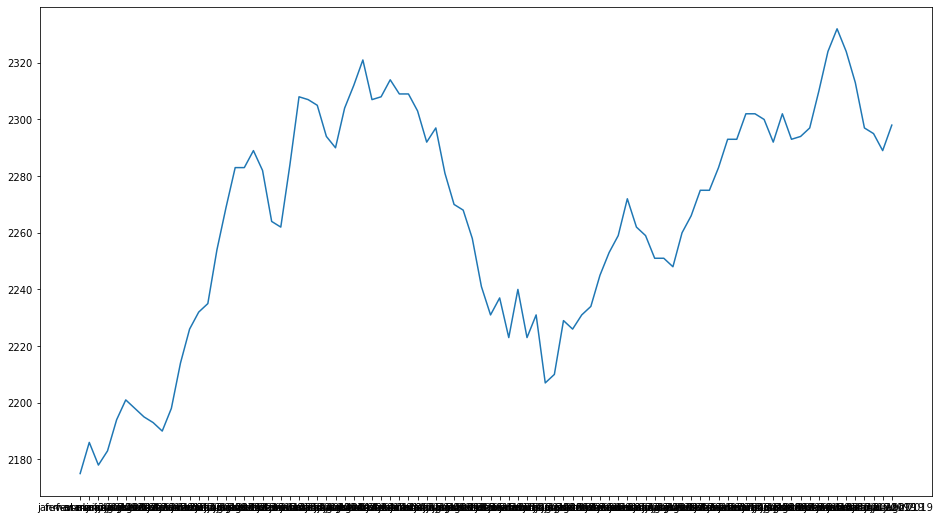

In [39]:
plt.figure(figsize=(16,9))
plt.plot(wage[0])
plt.show()

In [40]:
def stationarity_test(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(16,9))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

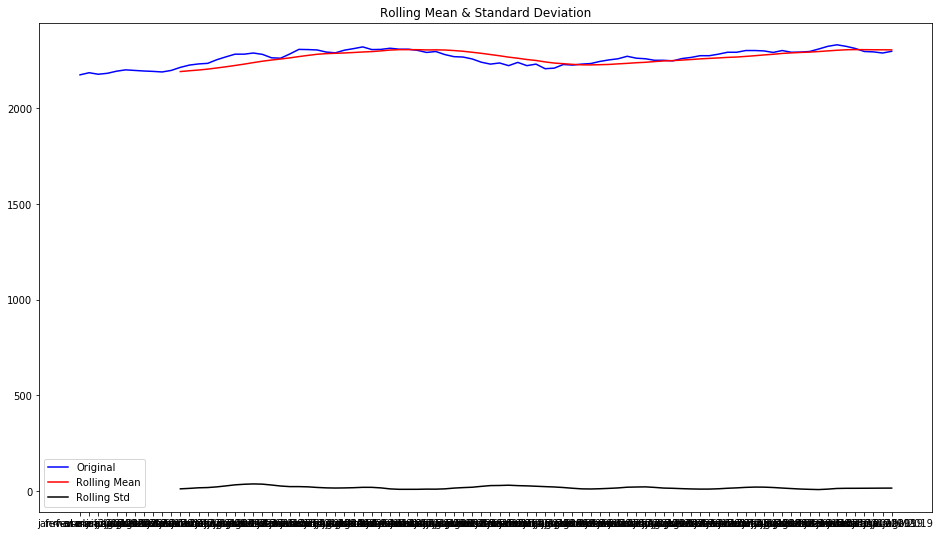

In [41]:
stationarity_test(wage[0])

In [42]:
def difference(dataset, interval=1):
    index = list(dataset.index)
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[0][i] - dataset[0][i - interval]
        diff.append(value)
    return (diff)

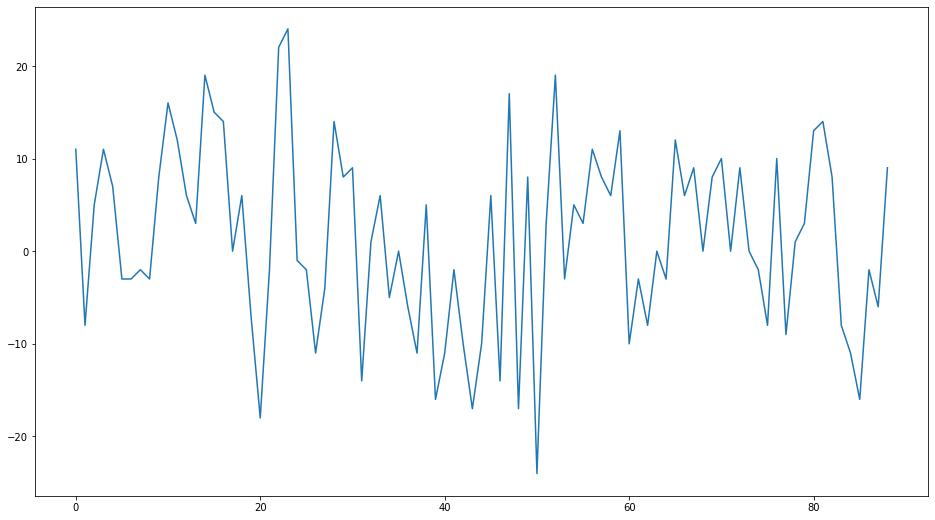

In [43]:
diff = difference(wage)
plt.figure(figsize=(16,9))
plt.plot(diff)
plt.show()